In [ ]:
%matplotlib inline
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=bd98184abf216763153ad9ab3e1f0a3dff929fd1716df8f27b46cc53954f5cf4
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=cfe11699502a0d04e705cc0124332232b91d8aa9fed3240aef341f1e5856d096
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/dow

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2023-06-10 09:42:03--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-06-10 09:42:03 (14.0 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-06-10 09:42:03--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.61, 99.84.160.46, 99.84.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2023-06-10 09:42:03 (9.07 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-06-10 09:42:03--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.61, 99.84.160.46, 99.84.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [ ]:
mesh

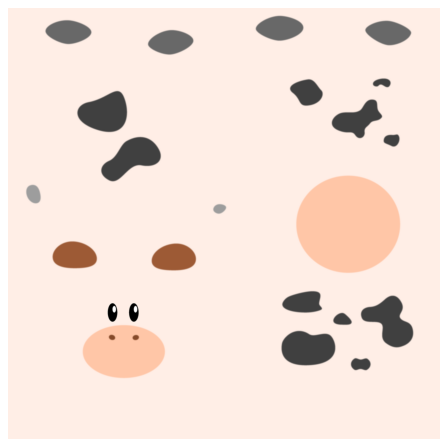

In [ ]:
import matplotlib
%matplotlib inline
#matplotlib.use('Agg')

plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");
plt.show()


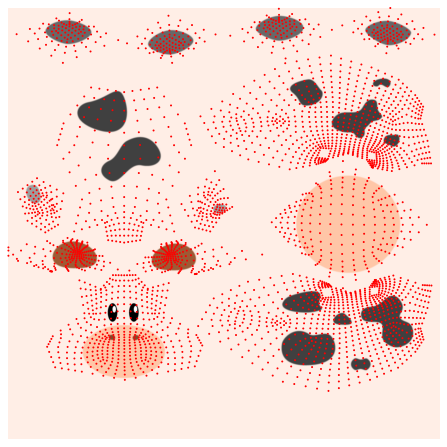

In [ ]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");


In [ ]:
# Create a renderer 

In [ ]:
# A renderer in PyTorch3D is composed of a rasterizer and a shader which each have a number of subcomponents such as a camera (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

#In this example we will first create a renderer which uses a perspective camera, a point light and applies Phong shading. Then we learn how to vary different components using the modular API.

In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

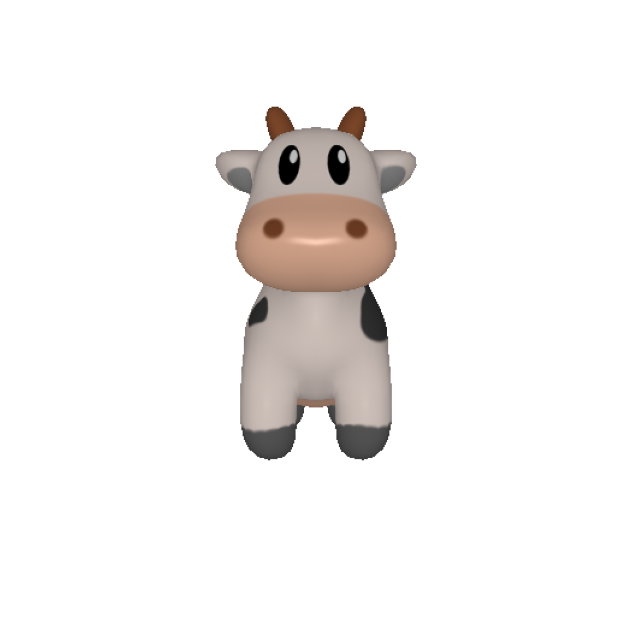

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

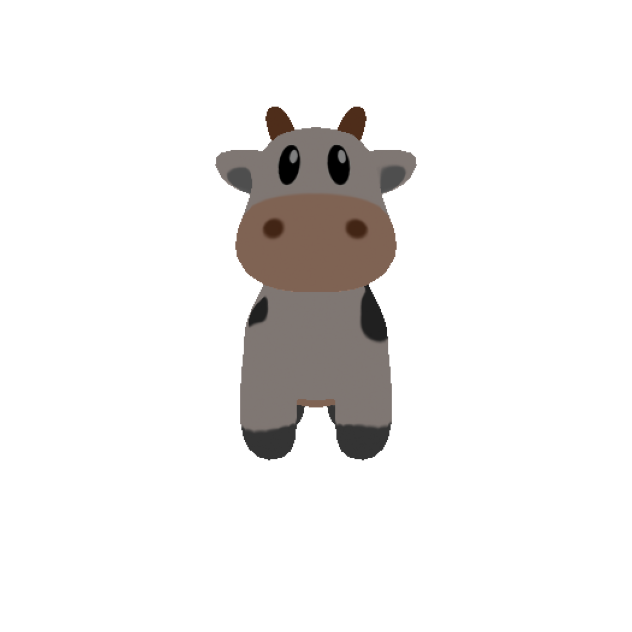

In [ ]:
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
# Rotate the object, modify the material properties or light properties

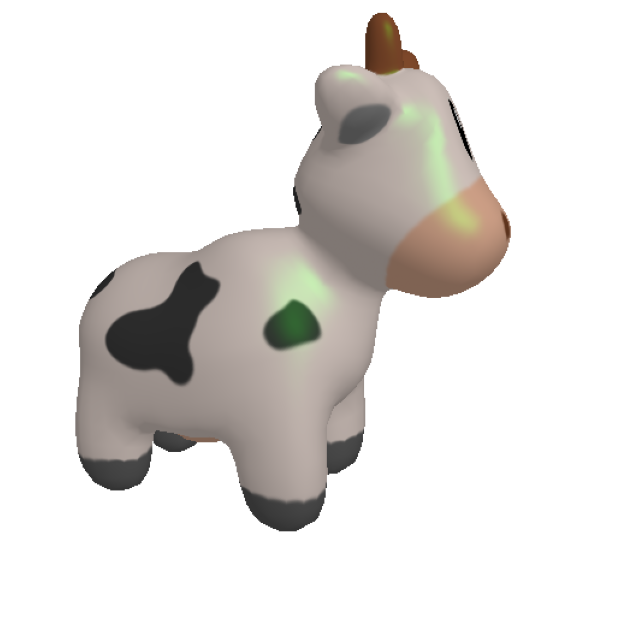

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2, elev=10, azim=-250)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
## Doly zoom  effect : change field of view by changing focal length of the camera 

tensor([120.0000, 112.2222, 104.4444,  96.6667,  88.8889,  81.1111,  73.3333,
         65.5556,  57.7778,  50.0000])


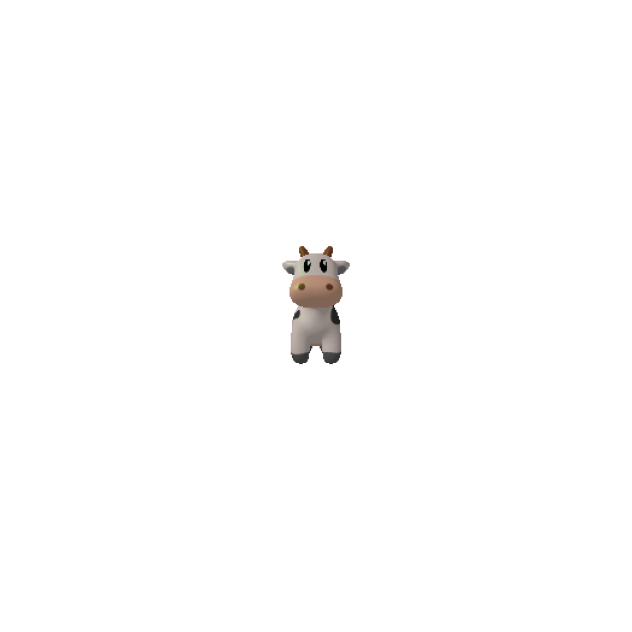

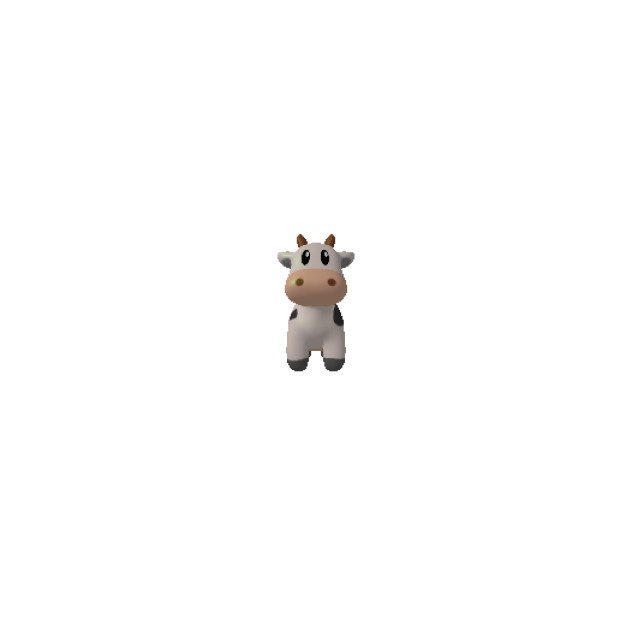

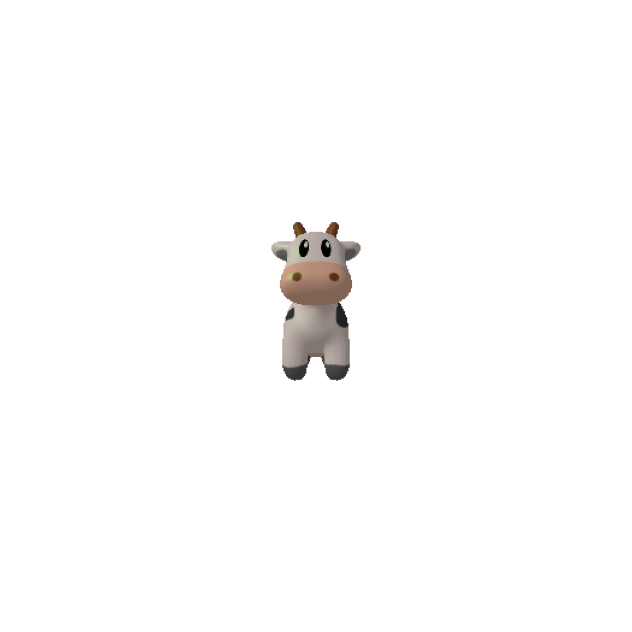

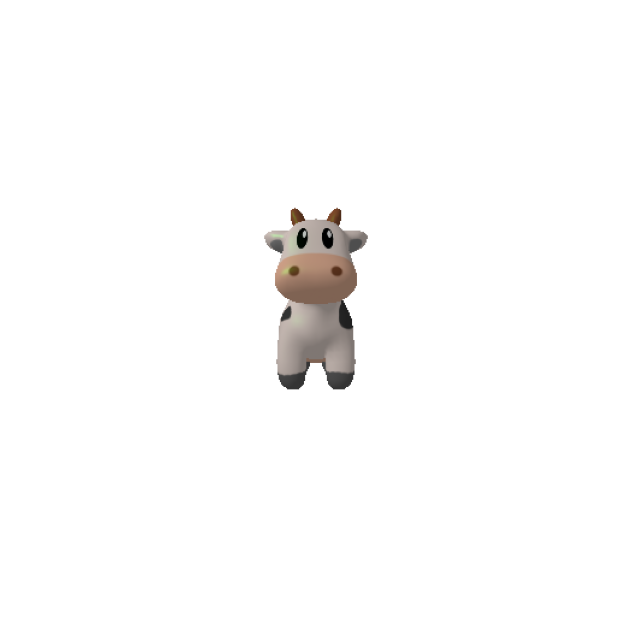

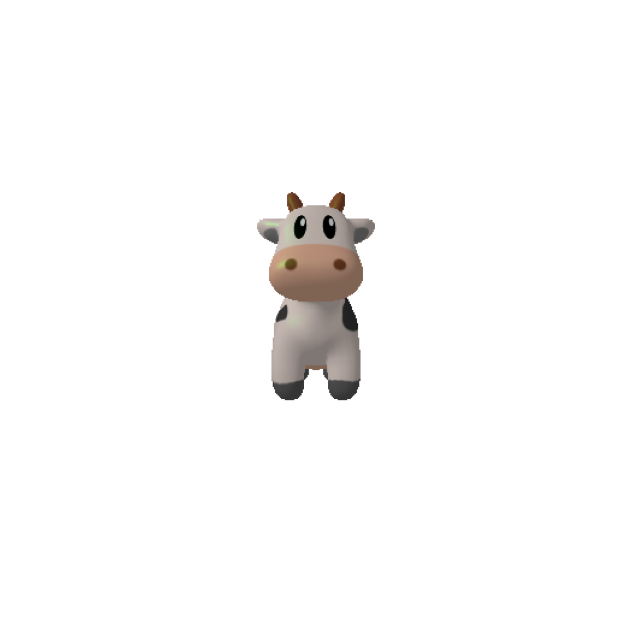

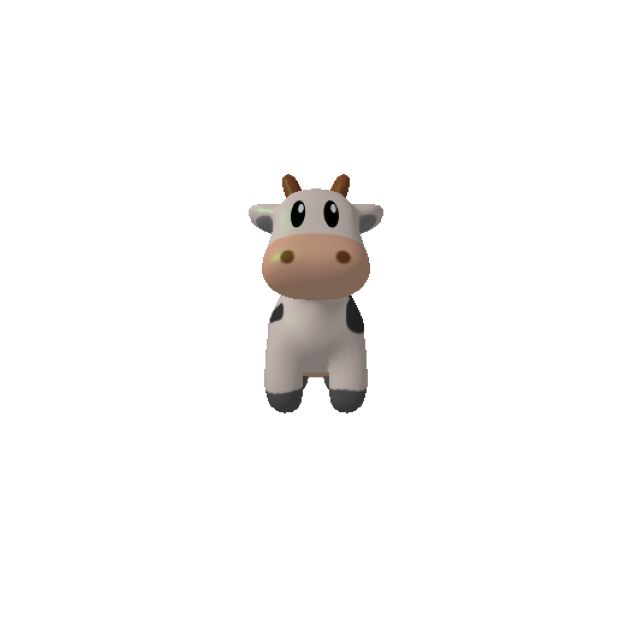

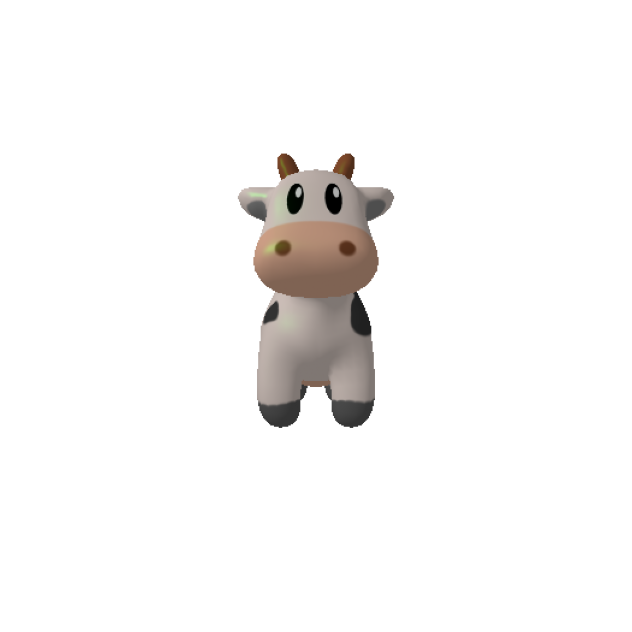

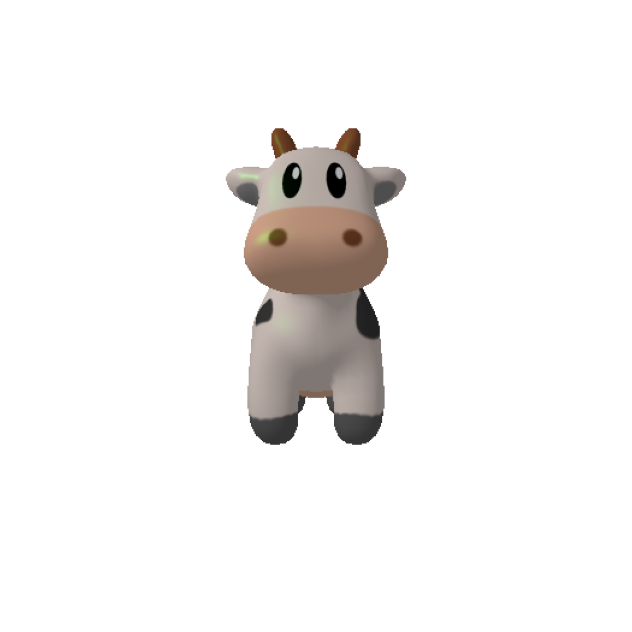

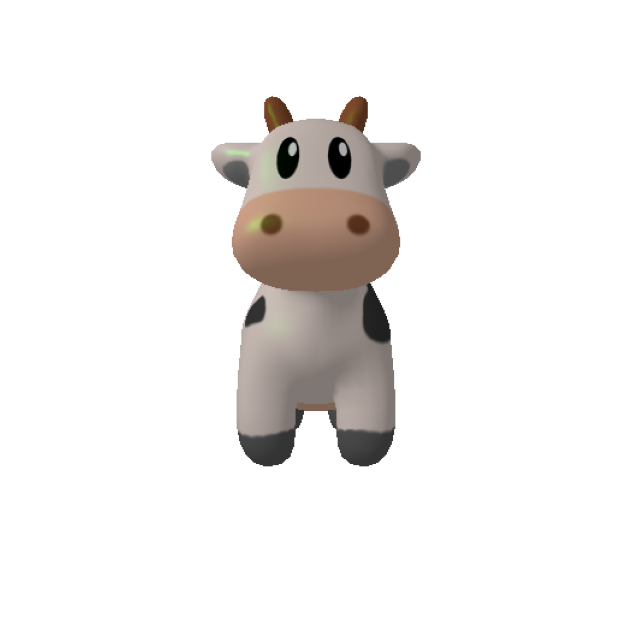

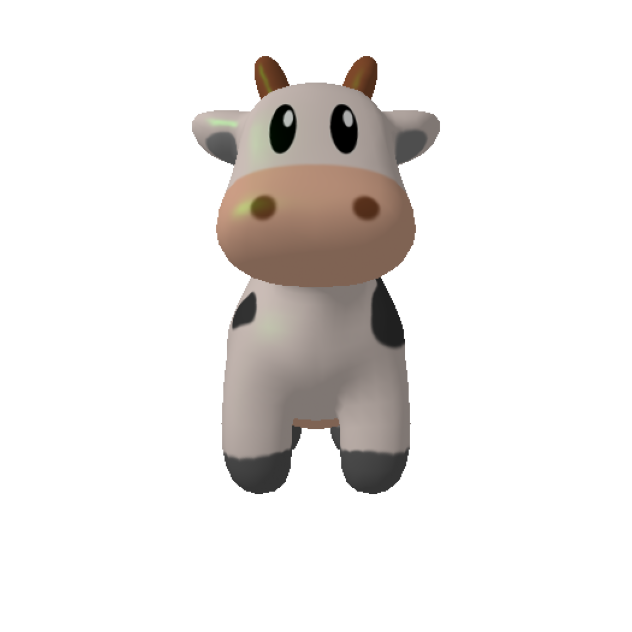

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(2.7, 0, 180) 
num_frames = 10


# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

fovs = torch.linspace(120,50, num_frames)
print (fovs)
for fov in fovs:
  cameras = FoVPerspectiveCameras(device=device, R=R, T=T,fov=fov)
  # Re render the mesh, passing in keyword arguments for the modified components.
  images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

  plt.figure(figsize=(10, 10))
  plt.imshow(images[0, ..., :3].cpu().numpy())
  plt.axis("off");
  plt.show()


In [ ]:
##Batched Rendering

In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

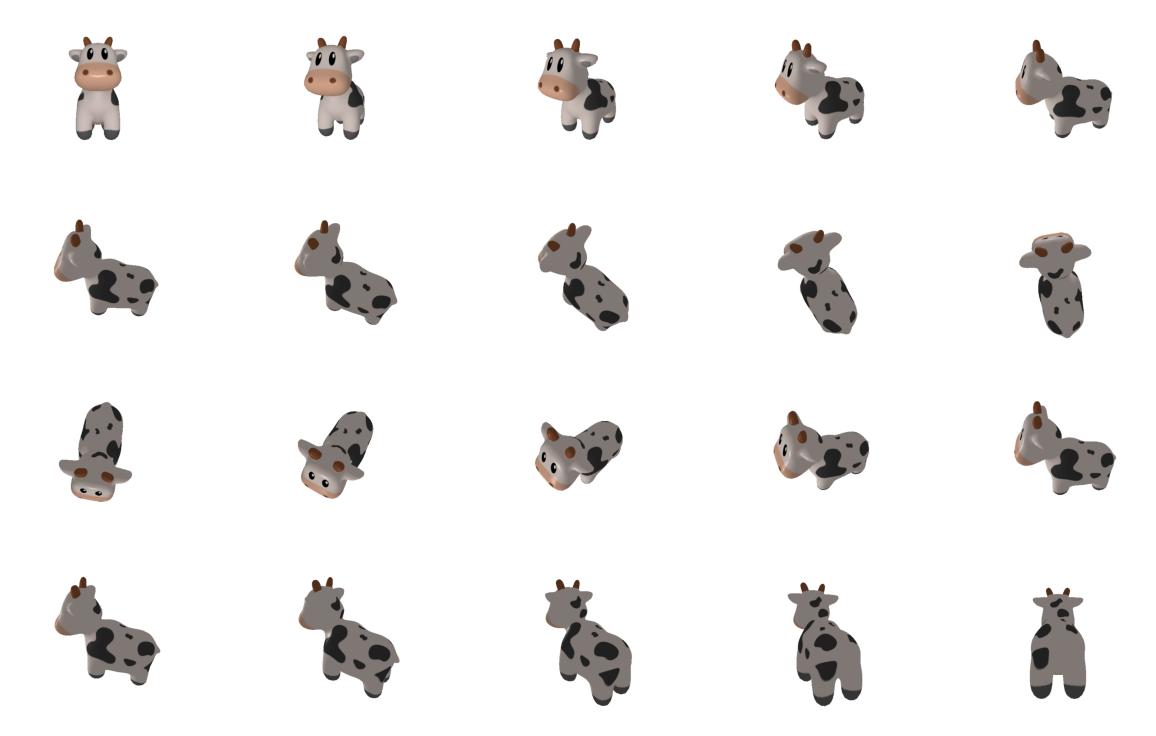

In [ ]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

In [ ]:
#Plotly visualization

In [ ]:
verts, faces_idx, _ = load_obj(obj_filename)
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()


In [ ]:
# use Plotly's default colors (no texture)
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)]
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

In [ ]:
# create a batch of meshes, and offset one to prevent overlap
mesh_batch = Meshes(
    verts=[verts.to(device), (verts + 2).to(device)],   
    faces=[faces.to(device), faces.to(device)]
)

# plot mesh batch in the same trace
fig = plot_scene({
    "subplot1": {
        "cow_mesh_batch": mesh_batch
    }
})
fig.show()

In [ ]:
# create a batch of meshes, and offset one to prevent overlap
mesh_batch = Meshes(
    verts=[verts.to(device), (verts + 2).to(device)],   
    faces=[faces.to(device), faces.to(device)]
)

# plot mesh batch in the same trace
fig = plot_scene({
    "subplot1": {
        "cow_mesh_batch": mesh_batch
    }
})
fig.show()

In [ ]:
# plot batch of meshes in different traces
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0],
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()

In [ ]:
# plot batch of meshes in different subplots
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0]
    },
    "subplot2":{
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()


In [ ]:
# extend the batch to have 4 meshes
mesh_4 = mesh_batch.extend(2)

# visualize the batch in different subplots, 2 per row
fig = plot_batch_individually(mesh_4)
# we can update the figure height and width
fig.update_layout(height=1000, width=500)
fig.show()


In [ ]:
fig2 = plot_scene({
    "cow_plot1": {
        "cows": mesh_batch
    }
},
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig2.show()

In [ ]:
fig3 = plot_batch_individually(
    mesh_4, 
    ncols=2,
    subplot_titles = ["cow1", "cow2", "cow3", "cow4"], # customize subplot titles
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig3.show()

In [ ]:
#2. Practicing with Meshes

In [29]:
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [30]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

NotImplementedError: ignored